# Exploratory Data Analysis - Insurance Policy Generation Chatbot

Exploratory Data Analysis (EDA) for textual data from PDFs is a multi-step process that involves:


## Setup & Initialization:

Let's Import dependencies and initialize some variables.


In [20]:
%pip install -r requirements.txt >> /dev/null

Note: you may need to restart the kernel to use updated packages.


In [25]:
%load_ext autoreload
%autoreload 2

# import src modules
from src import config
from src import ETL

# import langchain related modules
from langchain.document_loaders import PyPDFDirectoryLoader
from langchain.text_splitter import (
    CharacterTextSplitter,
    RecursiveCharacterTextSplitter,
)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Extraction:

In this section, we will download the data from an s3 bucket and save it locally.


In [9]:
ETL.extract_from_s3(
    config.S3_BUCKET_NAME,
    config.S3_BUCKET_PREFIX,
    config.AWS_ACCESS_KEY_ID,
    config.AWS_SECRET_ACCESS_KEY,
    config.DATASET_ROOT_PATH,
)

Files from anyoneai-datasets/queplan_insurance/ already downloaded to /home/gio/ANYONEAI/InsurancePolicyChatbot/notebooks/dataset.


## Document Loading:

Now let's load the PDFs containing Insurance Policies using PyPDFDirectoryLoader from LangChain.


In [10]:
loader = PyPDFDirectoryLoader(config.DATASET_ROOT_PATH)

documents = loader.load()

Each Page is a `Document`.

A `Document` contains text (`page_content`) and `metadata`


In [11]:
print(f"Number of pages: {len(documents)}")

Number of pages: 267


Let's take a look at it's metadata. We can see that it contains the following fields:

- `source` : The source of the document
- `page` : The page number of the document

this information can be used to trace back the document to the source for debugging purposes.


In [12]:
print("The Page's File name is: ", documents[0].metadata["source"])

print("The Page number is: ", documents[0].metadata["page"])

The Page's File name is:  /home/gio/ANYONEAI/InsurancePolicyChatbot/notebooks/dataset/POL320130223.pdf
The Page number is:  0


We can also add custom metadata to the document. Let's add a `policy_title` field to the metadata. This will be useful for us later on.

For this, we need to reload the documents with the new metadata.


In [13]:
documents = ETL.load_documents_with_title(config.DATASET_ROOT_PATH)

In [14]:
print(f"Number of pages: {len(documents)}")

print("The Page's File name is: ", documents[50].metadata["source"])

print("The Page number is: ", documents[50].metadata["page"])

print("The Policy's Title is: ", documents[50].metadata["title"])

Number of pages: 267
The Page's File name is:  /home/gio/ANYONEAI/InsurancePolicyChatbot/notebooks/dataset/POL320200214.pdf
The Page number is:  3
The Policy's Title is:  SEGURO PARA PRESTACIONES MÉDICAS DE ALTO COSTO


Now, let's look at a glimpse of the first page of the first document.


In [15]:
print(documents[0].page_content[0:500], "...")

SEGURO COLECTIVO COMPLEMENTARIO DE SALUD 
Incorporada al Depósito de Pólizas bajo el código POL320130223
ARTICULO 1°: REGLAS APLICABLES AL CONTRATO
 
 
 
 
 
 
 
Se aplicarán al presente contrato de seguro las disposiciones contenidas en los artículos siguientes y las
normas legales de carácter imperativo establecidas en el Título VIII, del Libro II, del Código de Comercio. Sin
embargo, se entenderán válidas las estipulaciones contractuales que sean más beneficiosas para el
asegurado o beneficia ...


The reason why we explore the first page of the first document is to get a sense of the structure of the document. This analisis will help us in the next step which is the Document Splitting phase, where we will split the document into chunks to feed our vector store. In order to ensure that each chunk has coherent, self-contained information, we need to define de appropriate chunk size.

Given the content of our dataset, the logical division would be to break down by articles and major subheadings since they seem to encapsulate a singular topic or concept.


## Preprocessing:

However, we see the presence of a lot of whitespace and empty lines across the dataset. This might interfere with the chunking process and produce poor results. Therefore, we will preprocess the data to remove the empty lines and whitespace.


In [16]:
# This function will clean the pages from extra whitespaces and newlines
ETL.preprocess(documents)

[Document(page_content='SEGURO COLECTIVO COMPLEMENTARIO DE SALUD \nIncorporada al Depósito de Pólizas bajo el código POL320130223\nARTICULO 1°: REGLAS APLICABLES AL CONTRATO\n\nSe aplicarán al presente contrato de seguro las disposiciones contenidas en los artículos siguientes y las\nnormas legales de carácter imperativo establecidas en el Título VIII, del Libro II, del Código de Comercio. Sin\nembargo, se entenderán válidas las estipulaciones contractuales que sean más beneficiosas para el\nasegurado o beneficiario.\n\nARTÍCULO Nº 2: COBERTURA\n\nLa compañía de seguros bajo las condiciones y términos que más adelante se establecen, conviene en\nreembolsar o pagar al beneficiario, los gastos médicos razonables y acostumbrados en que haya incurrido\nefectivamente un asegurado, en complemento de lo que cubra el sistema de salud previsional o de bienestar\nu otro seguro o convenio, a consecuencia de una incapacidad cubierta.', metadata={'source': '/home/gio/ANYONEAI/InsurancePolicyChatbot

In [17]:
print(documents[0].page_content)

SEGURO COLECTIVO COMPLEMENTARIO DE SALUD 
Incorporada al Depósito de Pólizas bajo el código POL320130223
ARTICULO 1°: REGLAS APLICABLES AL CONTRATO

Se aplicarán al presente contrato de seguro las disposiciones contenidas en los artículos siguientes y las
normas legales de carácter imperativo establecidas en el Título VIII, del Libro II, del Código de Comercio. Sin
embargo, se entenderán válidas las estipulaciones contractuales que sean más beneficiosas para el
asegurado o beneficiario.

ARTÍCULO Nº 2: COBERTURA

La compañía de seguros bajo las condiciones y términos que más adelante se establecen, conviene en
reembolsar o pagar al beneficiario, los gastos médicos razonables y acostumbrados en que haya incurrido
efectivamente un asegurado, en complemento de lo que cubra el sistema de salud previsional o de bienestar
u otro seguro o convenio, a consecuencia de una incapacidad cubierta.


Now that we have preprocessed the data, we can proceed to build our LLM.


## Document Analysis:

In this section, we will analyze the documents to extract some insights about the dataset.

### Distribution of Document Lengths:

Let's plot the distribution of document lengths to get a sense of the dataset.

/home/gio/ANYONEAI/InsurancePolicyChatbot/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gio/ANYONEAI/InsurancePolicyChatbot/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


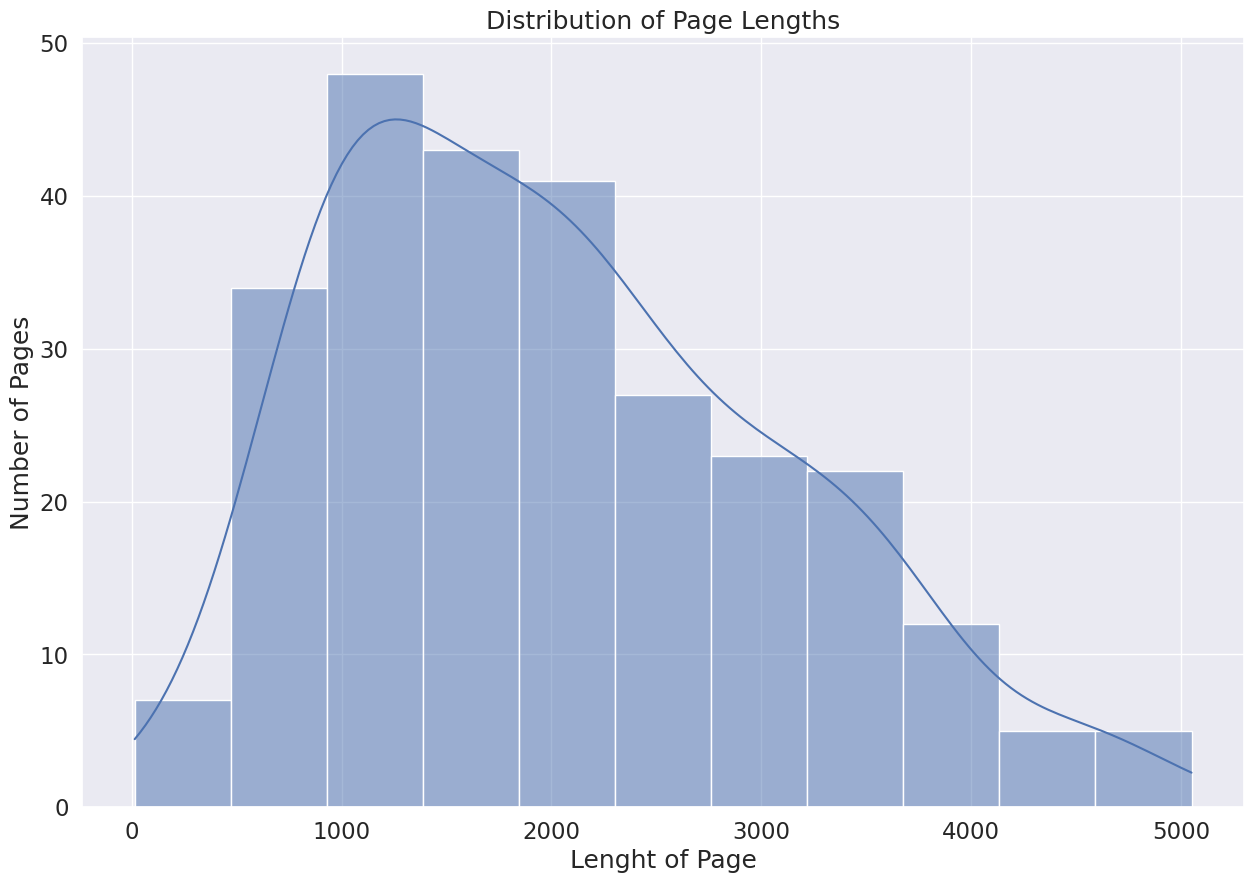

In [36]:
dataset = list(map(lambda x: len(x.page_content), documents))

df = pd.DataFrame(dataset, columns=["page_length"])

sns.set_style("whitegrid")
sns.set(rc={"figure.figsize": (15, 10)})
sns.set(font_scale=1.5)

sns.histplot(data=df, x="page_length", kde=True)
plt.title("Distribution of Page Lengths")
plt.xlabel("Lenght of Page")
plt.ylabel("Number of Pages")
plt.show()

This graph is telling us that most of the pages are of length 1000-2000 words. This data will become relevant at deciding the chunk size for the LLM.

## Document Splitting

Now, let's split the document into chunks of text for further processing.


### Chunking Considerations

Several variables play a role in determining the best chunking strategy, and these variables vary depending on the use case. Here are some key aspects to keep in mind:

1. **What is the nature of the content being indexed?**

   Based on the content of the dataset, we're working with insurance policies. The logical division would be to break down by articles and major subheadings since they seem to encapsulate a singular topic or concept.

2. **Which embedding model will be used, and what chunk sizes does it perform optimally on?**

   We will be using OpenAI GPT-3.5 Turbo, which performs optimally on chunks of 512 tokens.

3. **What are your expectations for the length and complexity of user queries?**

   Since this solution will act as a chatbot, we can expect the queries to be mostly short and simple. However, we should also consider the possibility of more complex queries, such as "Cual es la diferencia entre el seguro de vida y el seguro de salud?" (What is the difference between life insurance and health insurance?)

4. **How will the retrieved results be utilized within your specific application?**

   The retrieved results will be used to answer user queries. The user will be able to ask questions about the content of the documents, and the chatbot will respond with the most relevant information.


### Chunking methods

There are different methods for chunking, and each of them might be appropriate for different situations. By examining the strengths and weaknesses of each method, our goal is to identify the right scenario to apply them to.


#### Fixed-size chunking

This is the most common and straightforward approach to chunking: we simply decide the number of tokens in our chunk and, optionally, whether there should be any overlap between them.


In [48]:
c_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=150, separator="\n")

c_splitter_result = c_splitter.split_documents(documents)

print("Chunk Size count: ", len(c_splitter_result))

print(c_splitter_result[0].page_content)
print("-------------------")
print(c_splitter_result[1].page_content)
print("-------------------")
print(c_splitter_result[2].page_content)

Chunk Size count:  724
SEGURO COLECTIVO COMPLEMENTARIO DE SALUD 
Incorporada al Depósito de Pólizas bajo el código POL320130223
ARTICULO 1°: REGLAS APLICABLES AL CONTRATO
Se aplicarán al presente contrato de seguro las disposiciones contenidas en los artículos siguientes y las
normas legales de carácter imperativo establecidas en el Título VIII, del Libro II, del Código de Comercio. Sin
embargo, se entenderán válidas las estipulaciones contractuales que sean más beneficiosas para el
asegurado o beneficiario.
ARTÍCULO Nº 2: COBERTURA
La compañía de seguros bajo las condiciones y términos que más adelante se establecen, conviene en
reembolsar o pagar al beneficiario, los gastos médicos razonables y acostumbrados en que haya incurrido
efectivamente un asegurado, en complemento de lo que cubra el sistema de salud previsional o de bienestar
u otro seguro o convenio, a consecuencia de una incapacidad cubierta.
-------------------
Se otorgará cobertura a los gastos médicos incurridos por los 

Let's graph the distribution of chunk lengths to get a sense of the dataset.

/home/gio/ANYONEAI/InsurancePolicyChatbot/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gio/ANYONEAI/InsurancePolicyChatbot/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


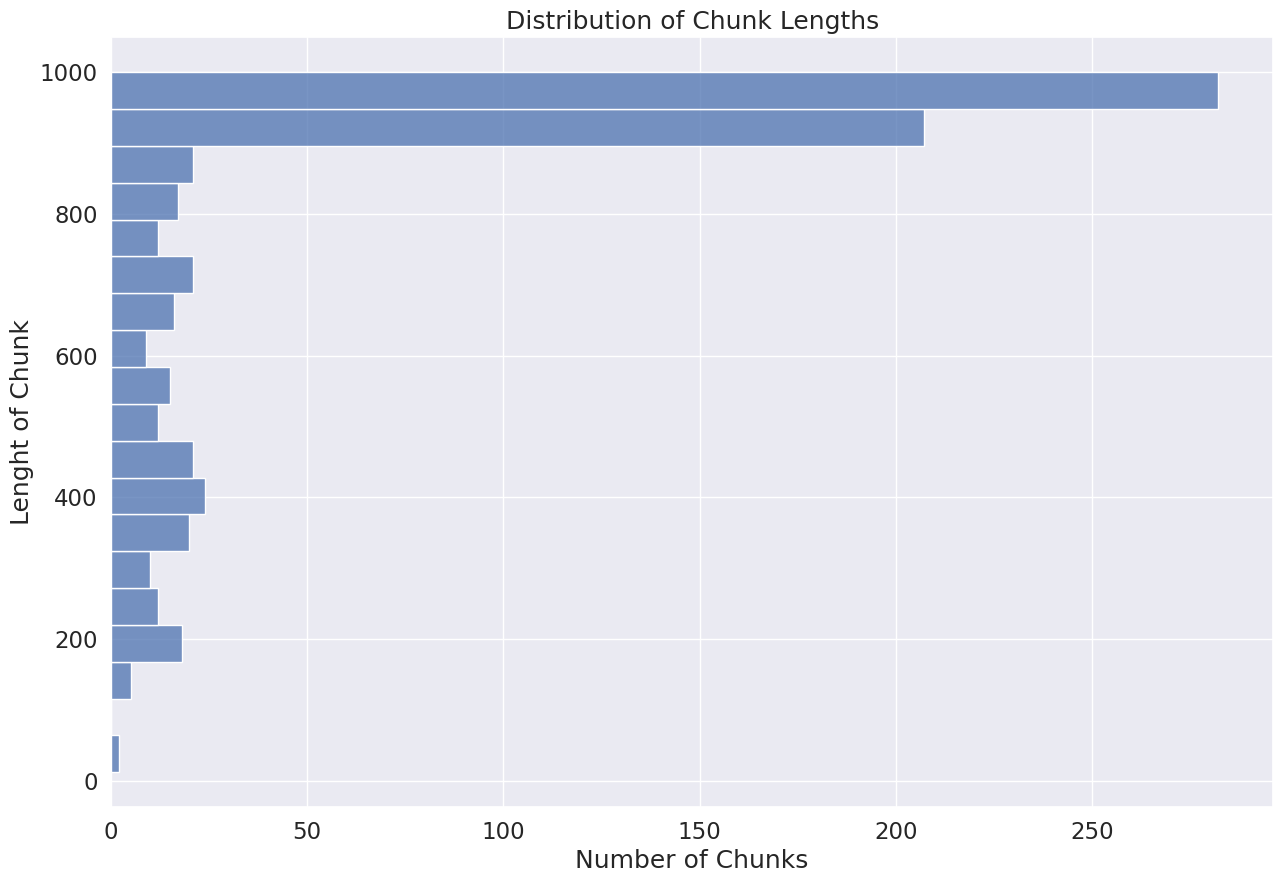

In [43]:
dataset = list(map(lambda x: len(x.page_content), c_splitter_result))

df = pd.DataFrame(dataset, columns=["page_length"])

sns.set_style("whitegrid")
sns.set(rc={"figure.figsize": (15, 10)})
sns.set(font_scale=1.5)

sns.histplot(data=df, y="page_length")
plt.title("Distribution of Chunk Lengths")
plt.ylabel("Lenght of Chunk")
plt.xlabel("Number of Chunks")
plt.show()


Let's try a smaller chunk size to see if we can get a better distribution.

In [49]:
c_splitter = CharacterTextSplitter(chunk_size=500, chunk_overlap=100, separator="\n")

c_splitter_result = c_splitter.split_documents(documents)

print("Chunk Size count: ", len(c_splitter_result))

print(c_splitter_result[0].page_content)
print("-------------------")
print(c_splitter_result[1].page_content)
print("-------------------")
print(c_splitter_result[2].page_content)

Chunk Size count:  1385
SEGURO COLECTIVO COMPLEMENTARIO DE SALUD 
Incorporada al Depósito de Pólizas bajo el código POL320130223
ARTICULO 1°: REGLAS APLICABLES AL CONTRATO
Se aplicarán al presente contrato de seguro las disposiciones contenidas en los artículos siguientes y las
normas legales de carácter imperativo establecidas en el Título VIII, del Libro II, del Código de Comercio. Sin
embargo, se entenderán válidas las estipulaciones contractuales que sean más beneficiosas para el
asegurado o beneficiario.
-------------------
asegurado o beneficiario.
ARTÍCULO Nº 2: COBERTURA
La compañía de seguros bajo las condiciones y términos que más adelante se establecen, conviene en
reembolsar o pagar al beneficiario, los gastos médicos razonables y acostumbrados en que haya incurrido
efectivamente un asegurado, en complemento de lo que cubra el sistema de salud previsional o de bienestar
u otro seguro o convenio, a consecuencia de una incapacidad cubierta.
-------------------
Se otorgará cob

/home/gio/ANYONEAI/InsurancePolicyChatbot/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gio/ANYONEAI/InsurancePolicyChatbot/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


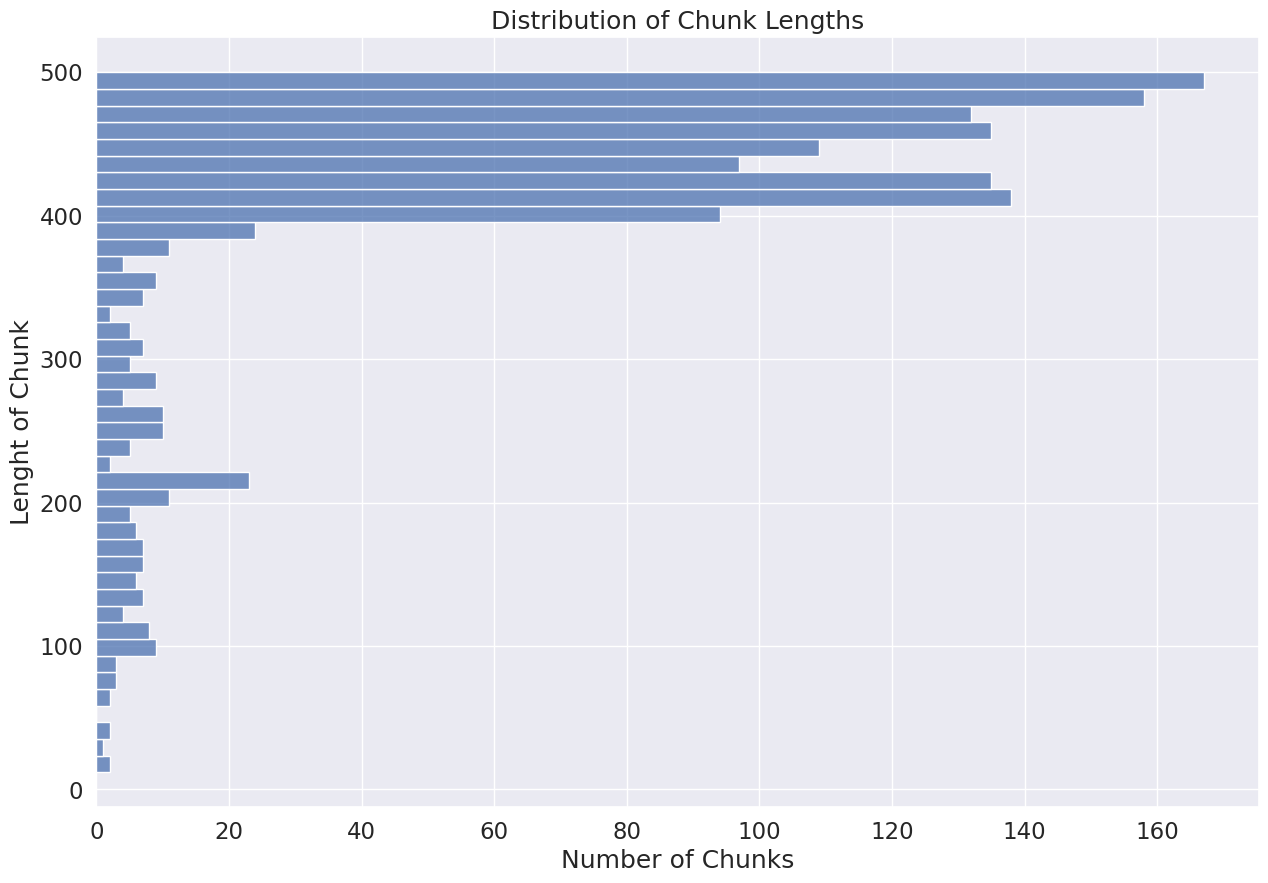

In [50]:
dataset = list(map(lambda x: len(x.page_content), c_splitter_result))

df = pd.DataFrame(dataset, columns=["page_length"])

sns.set_style("whitegrid")
sns.set(rc={"figure.figsize": (15, 10)})
sns.set(font_scale=1.5)

sns.histplot(data=df, y="page_length")
plt.title("Distribution of Chunk Lengths")
plt.ylabel("Lenght of Chunk")
plt.xlabel("Number of Chunks")
plt.show()


Much better but We are still seeing a lot of chunks with length 500. It's time to try another technique.

#### Recursive Chunking

Recursive chunking divides the input text into smaller chunks in a hierarchical and iterative manner using a set of separators. If the initial attempt at splitting the text doesn’t produce chunks of the desired size or structure, the method recursively calls itself on the resulting chunks with a different separator or criterion until the desired chunk size or structure is achieved. This means that while the chunks aren’t going to be exactly the same size, they’ll still “aspire” to be of a similar size.


In [46]:
r_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100,
    length_function=len,
    strip_whitespace=True,
)

r_splitter_result = r_splitter.split_documents(documents)

print("Chunk Size count: ", len(r_splitter_result))

print(r_splitter_result[0].page_content)
print("-------------------")
print(r_splitter_result[1].page_content)
print("-------------------")
print(r_splitter_result[2].page_content)

Chunk Size count:  1532
SEGURO COLECTIVO COMPLEMENTARIO DE SALUD 
Incorporada al Depósito de Pólizas bajo el código POL320130223
ARTICULO 1°: REGLAS APLICABLES AL CONTRATO

Se aplicarán al presente contrato de seguro las disposiciones contenidas en los artículos siguientes y las
normas legales de carácter imperativo establecidas en el Título VIII, del Libro II, del Código de Comercio. Sin
embargo, se entenderán válidas las estipulaciones contractuales que sean más beneficiosas para el
asegurado o beneficiario.
-------------------
ARTÍCULO Nº 2: COBERTURA

La compañía de seguros bajo las condiciones y términos que más adelante se establecen, conviene en
reembolsar o pagar al beneficiario, los gastos médicos razonables y acostumbrados en que haya incurrido
efectivamente un asegurado, en complemento de lo que cubra el sistema de salud previsional o de bienestar
u otro seguro o convenio, a consecuencia de una incapacidad cubierta.
-------------------
Se otorgará cobertura a los gastos médi

Let's graph the distribution again of chunk lengths to get a sense of the dataset.

/home/gio/ANYONEAI/InsurancePolicyChatbot/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gio/ANYONEAI/InsurancePolicyChatbot/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


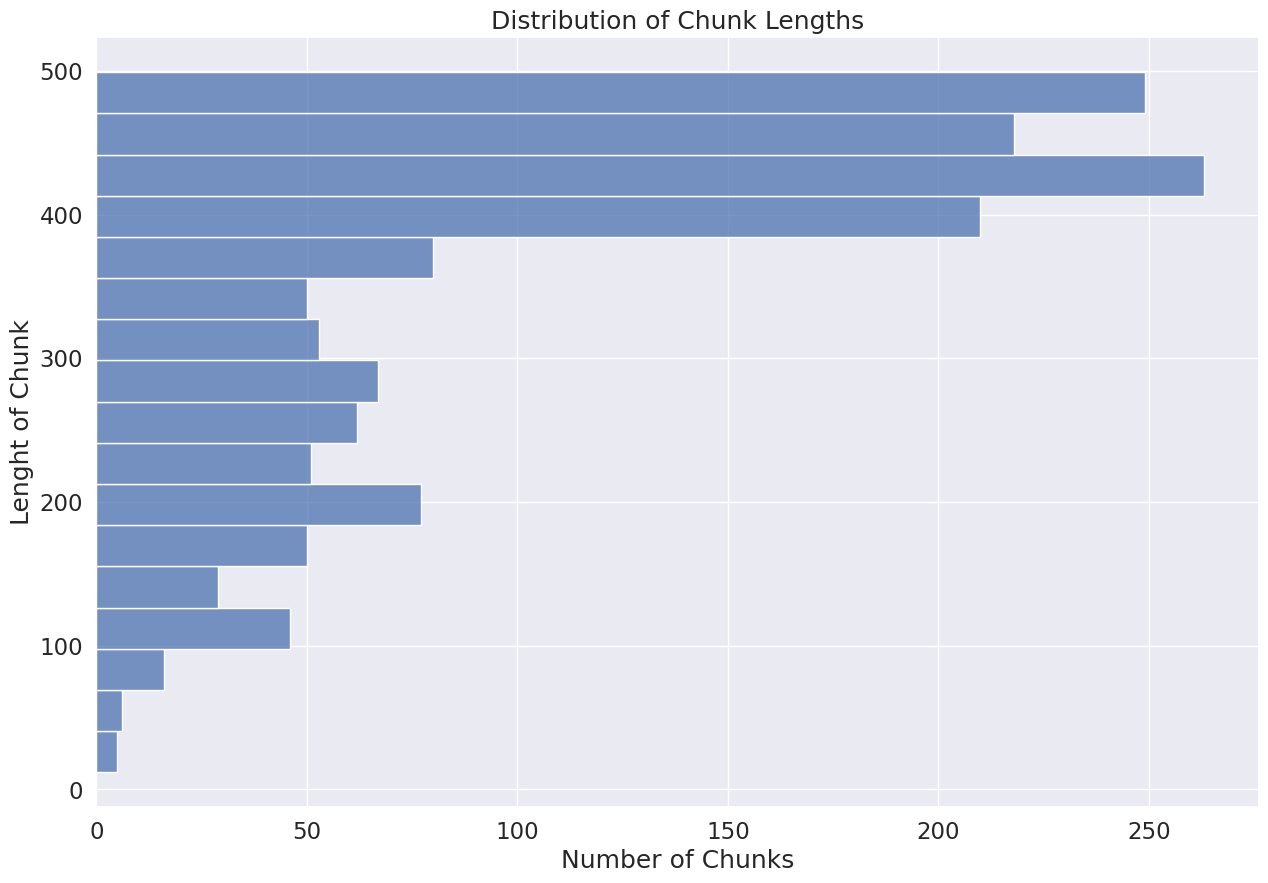

In [47]:
dataset = list(map(lambda x: len(x.page_content), r_splitter_result))

df = pd.DataFrame(dataset, columns=["page_length"])

sns.set_style("whitegrid")
sns.set(rc={"figure.figsize": (15, 10)})
sns.set(font_scale=1.5)

sns.histplot(data=df, y="page_length")
plt.title("Distribution of Chunk Lengths")
plt.ylabel("Lenght of Chunk")
plt.xlabel("Number of Chunks")
plt.show()

We can see that the distribution of the chunk lengths using the recursive splitter is more uniform than the distribution of the chunk lengths using the character splitter.